In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [388]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [389]:
df = pd.read_csv('data.csv', encoding='utf-8-sig', index_col=0)
# undersampling 으로 선택된 행들. Train set 으로 사용
df_balanced = pd.read_csv('data_balanced.csv', encoding='utf-8-sig', index_col=0)
# 선택되지 않은 행들. Test set 으로 사용
df_remaining = pd.read_csv('data_remaining.csv', encoding='utf-8-sig', index_col=0)

df_dropna = df.dropna()
df_balanced_dropna = df_balanced.dropna()
df_remaining_dropna = df_remaining.dropna()

In [390]:
print("0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주")
print("1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산")
print("2 -> 수도권 : 서울, 인천, 세종, 경기")
print()

region_counts = df['region'].value_counts()

total = df['region'].value_counts().sum()
for region, counts in enumerate(region_counts):
    print(f"{region} -> {counts} ({np.round(counts/total, 4)})")

0 -> 그 외 지방: 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
1 -> 수도권 외 광역시: 부산, 대구, 광주, 대전, 울산
2 -> 수도권 : 서울, 인천, 세종, 경기

0 -> 1424 (0.4725)
1 -> 875 (0.2903)
2 -> 715 (0.2372)


### L2 규제 Logistic regression 모델, VIF & 상관계수 확인

가중치 감쇠를 통한 feature selection 발생여부 확인

Sales-Employees, Sales-capital 간의 양의 상관관계가 존재함을 확인

Accuracy :  0.4099756690997567
f1-score (macro) :  0.39015112695637416
Columns:  ['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
class  0
[-0.01221202 -0.03580703 -0.03447759  0.02253709 -0.14512778 -0.09110105
 -0.0023714   0.16543468]
class  1
[ 0.05638475 -0.16244023 -0.27186375  0.04126106  0.05205362 -0.04554344
 -0.01340529 -0.43481851]
class  2
[-0.04417273  0.19824726  0.30634134 -0.06379815  0.09307417  0.13664449
  0.01577669  0.26938383]


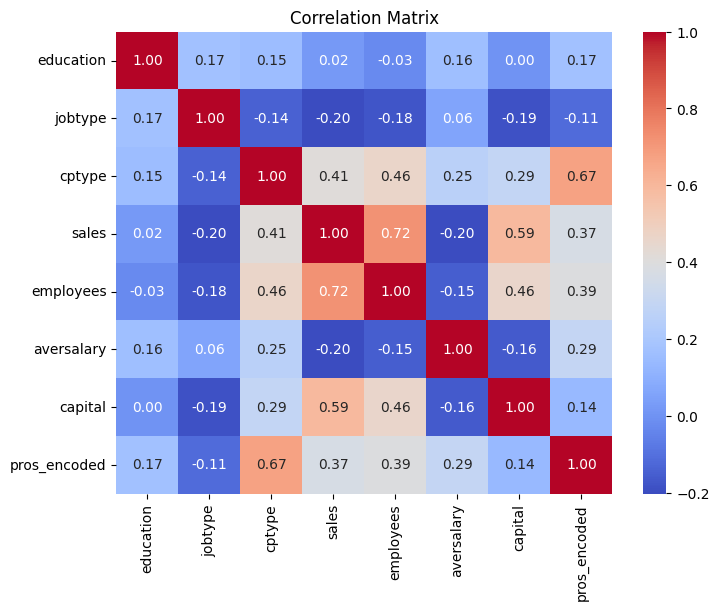

1.5949
1.6073
3.1204
3.7719
3.4178
1.6701
2.6787
2.3647


In [391]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_remaining_dropna.iloc[:, 1:]
y_test = df_remaining_dropna['region']

# Lasso classifier
# C is inverse of alpha
linear = LogisticRegression(penalty='l2', C=10)
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

# Score
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("f1-score (macro) : ", f1_score(y_test, y_pred, average='macro'))

# feature selection -> sales, employees, capital
print("Columns: ", df.columns.values)
for i in range(len(linear.coef_)):
    print("class ", i)
    coef_set = linear.coef_[i]
    print(coef_set)

# Correlation matrix
correlation_matrix = df.loc[:, 'education': 'pros_encoded'].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# VIF
for feature in range(len(df.columns[1:])):
    print(np.round(variance_inflation_factor(X_train, feature), 4))

### 결측값이 존재하는 행 탐색

In [392]:
nan_rows = df.isna().any(axis=1)

df_nan = df[nan_rows]

print(df_nan.describe())

df_nan.head()

            region    education      jobtype       cptype       sales  \
count  1362.000000  1362.000000  1362.000000  1362.000000  600.000000   
mean      0.734949     0.780470     0.464023     0.461821    6.692517   
std       0.781545     1.153011     0.498887     0.769799   12.811688   
min       0.000000     0.000000     0.000000     0.000000   -0.130200   
25%       0.000000     0.000000     0.000000     0.000000   -0.127200   
50%       1.000000     0.000000     0.000000     0.000000    0.000000   
75%       1.000000     1.000000     1.000000     1.000000    5.933400   
max       2.000000     5.000000     1.000000     2.000000   95.856900   

        employees  aversalary    capital  pros_encoded  
count  829.000000  497.000000  650.00000   1362.000000  
mean     1.230340   -0.180477   68.75026     -0.095374  
std      4.171746    0.626951  188.54690      0.536237  
min     -0.209200   -1.521700   -0.11300     -0.500000  
25%     -0.203600   -0.565200   -0.11070     -0.500000  


,region,education,jobtype,cptype,sales,employees,aversalary,capital,pros_encoded
2,2,0,0,0,95.8569,10.7799,0.8261,NaN,0.95
3,2,0,1,1,21.3606,12.3409,NaN,NaN,0.40
6,2,0,1,0,NaN,NaN,NaN,NaN,0.05
7,2,1,1,1,1.3717,0.8855,1.5652,NaN,0.60
13,2,0,1,2,0.3120,-0.0272,NaN,5.8862,1.00


<h5> 대부분의 결측값은 중소기업에 해당함을 확인 </h5>

In [393]:
print("지역에 따른 결측값 분포: \n", df_nan['region'].value_counts())
print("회사 규모에 따른 결측값 분포: \n", df_nan['cptype'].value_counts())

지역에 따른 결측값 분포: 
 region
0    644
1    435
2    283
Name: count, dtype: int64
회사 규모에 따른 결측값 분포: 
 cptype
0    967
2    234
1    161
Name: count, dtype: int64


### Xgboost classifier


### Balanced dataset (undersampling) - No drop na  

결측값에도 필요한 정보가 존재할 수 있다고 생각되므로 단순히 drop 처리하기 껄끄럽다,    
결측값에 대한 별도 처리가 필요없는 Xgboost Classifier 모델 사용  

확인된 상관관계는 xgboost 알고리즘 특성상 모델 성능에 영향이 미미할 것이라 간주하고 이에 대한 처리를 수행하지 않았다.

In [394]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

X_test = df_remaining.iloc[:, 1:]
y_test = df_remaining['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

accuracy: 0.4478
f1-score (macro) : 0.4334


### 예측결과에 대한 Confusion matrix

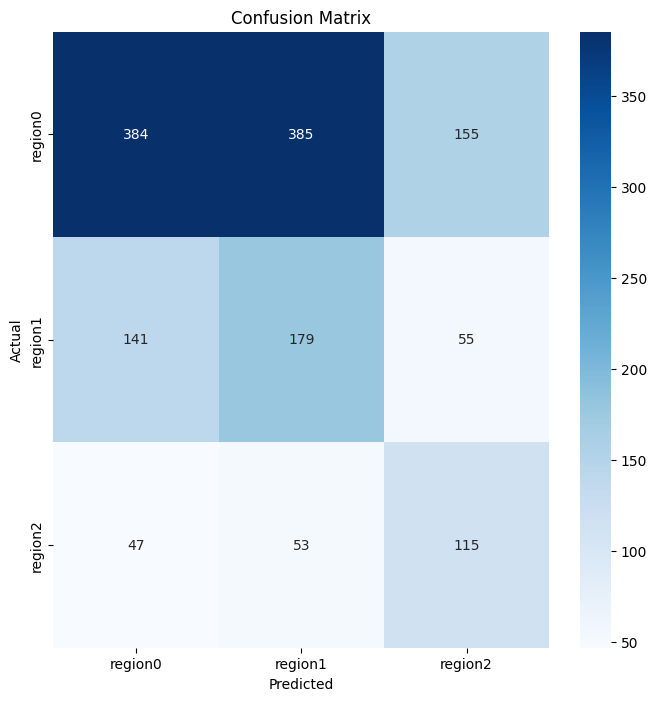

f1_score of class 0 : 0.51
recall_score of class 0 : 0.42
precision_score of class 0 : 0.67

f1_score of class 1 : 0.36
recall_score of class 1 : 0.48
precision_score of class 1 : 0.29

f1_score of class 2 : 0.43
recall_score of class 2 : 0.53
precision_score of class 2 : 0.35

accuracy: 0.4478
f1-score (macro) : 0.4334


In [395]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

### Balanced dataset (undersampling) , 결측값 drop 시

region 0 에 대해서만 f1-score 증가.

drop 하면서 제거된 행데이터들의 분포는 주로 region 0 (지방), cptype 0 (중소기업) 이었다.  
성능은 소폭 증가했지만, 정보손실과 일반화 성능을 고려해 dropna 하지 않기로 결정

In [396]:
X_train = df_balanced_dropna.iloc[:, 1:]
y_train = df_balanced_dropna['region']

X_test = df_remaining_dropna.iloc[:, 1:]
y_test = df_remaining_dropna['region']

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    objective="multi:softmax",
    num_class=3,
    eval_metric=["mlogloss"],
)

xgb_clf.fit(
    X_train,
    y_train,
    verbose=0,  # set to 1 to see xgb training round intermediate results
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

y_pred = xgb_clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

accuracy: 0.5085
f1-score (macro) : 0.4689


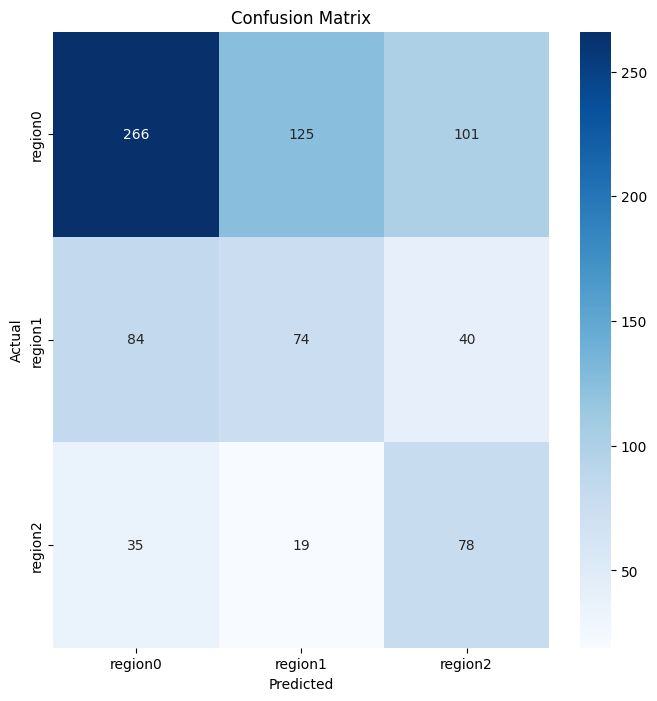

f1_score of class 0 : 0.61
recall_score of class 0 : 0.54
precision_score of class 0 : 0.69

f1_score of class 1 : 0.36
recall_score of class 1 : 0.37
precision_score of class 1 : 0.34

f1_score of class 2 : 0.44
recall_score of class 2 : 0.59
precision_score of class 2 : 0.36

accuracy: 0.5085
f1-score (macro) : 0.4689


In [397]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

### 최종 모델에 사용할 데이터셋 확정  
Train set :  
Undersampling, dropna X  

Test set :  
Undersampling, dropna X

실제 real world 데이터는 수집한 데이터 data.csv 와 달리 region 2 값이 다수이다.  

하지만 편의상 test data 는 data.csv 에서 클래스별로 동일한 갯수만큼 샘플링한 data_balanced.csv 를 추출하고 남은,  
data_remaing.csv 에서 언더샘플링한 데이터를 사용했다.  

In [398]:
X_train = df_balanced.iloc[:, 1:]
y_train = df_balanced['region']

# X_test = df_remaining.iloc[:, 1:]
# y_test = df_remaining['region']

df_remaining['region'].value_counts()

test_c0 = df_remaining[df_remaining['region'] == 0].sample(n=200, replace=False, random_state=222)
test_c1 = df_remaining[df_remaining['region'] == 1].sample(n=200, replace=False, random_state=222)
test_c2 = df_remaining[df_remaining['region'] == 2].sample(n=200, replace=False, random_state=222)

df_remaining_balanced = pd.concat([test_c0, test_c1, test_c2])
df_remaining_balanced.reset_index(drop=True, inplace=True)

X_test = df_remaining_balanced.iloc[:, 1:]
y_test = df_remaining_balanced['region']

### 하이퍼 파라미터 튜닝

아래 코드 실행시 결과  
Best Parameters:  {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.62}  
Best Score:  0.5039627039627039

In [399]:
# param_dist = {
#     'n_estimators' : np.arange(10, 210, 10),
#     'learning_rate' : np.arange(0, 1, 0.02),
#     'max_depth' : np.arange(1, 5),
# }

# xgb_clf = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric=['mlogloss'],)


# xgb_clf_tuned = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=100, random_state=4885, cv=3)

# xgb_clf_tuned.fit(X_train, y_train)

# print("Best Parameters: ", xgb_clf_tuned.best_params_)
# print("Best Score: ", xgb_clf_tuned.best_score_)

### 튜닝된 모델로 예측 및 예측결과 시각화  

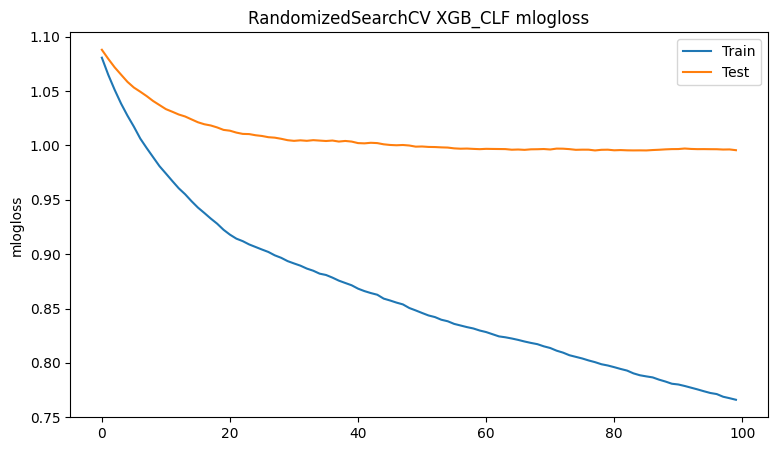

acc: 0.5083
f1-score (macro) : 0.5083


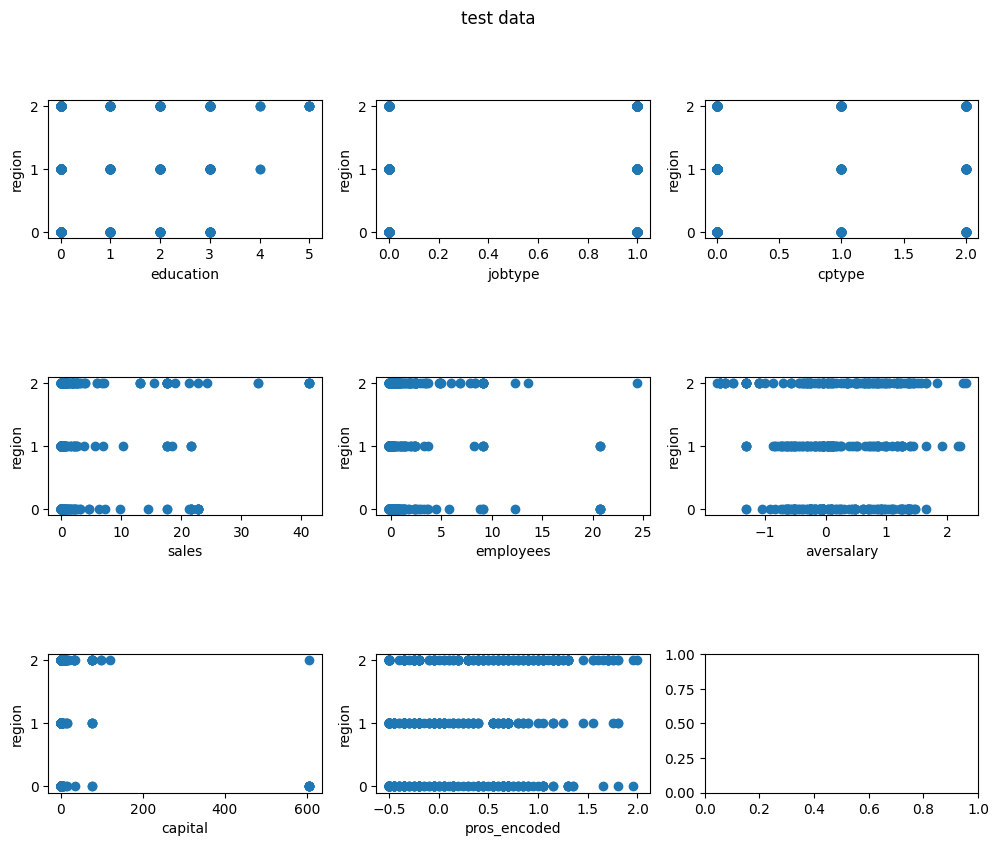

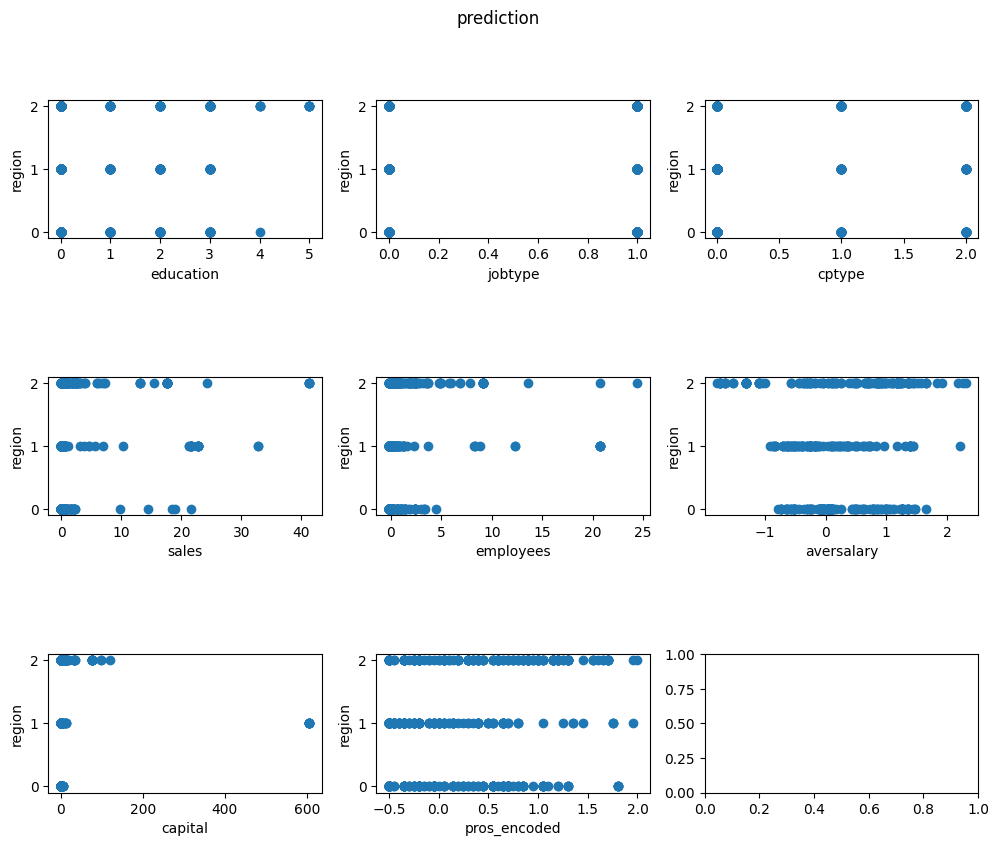

In [400]:
# best_params : {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.62}

xgb_clf_tuned = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    eval_metric=['mlogloss'],
    n_estimators = 190,
    max_depth = 4,
    learning_rate = 0.62,
    )

xgb_clf_tuned.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])
            # eval_set=[(X_train, y_train)])

# ----- 학습 epoch 당 모델 score (여기서는 mlogloss) 변화 시각화 -----
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('RandomizedSearchCV XGB_CLF mlogloss')
plt.show()

y_pred = xgb_clf_tuned.predict(X_test)

print(f"acc: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

# ----- X_test - y_test 산점도 -----
features = df.columns[1:]

fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))

fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_test)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
    axes[axe_row, axe_col].set_ylabel('region')
plt.suptitle("test data")
plt.show()

# ----- X_test - y_pred 산점도 -----
fig, axes = plt.subplots(nrows= 3, ncols=3, figsize=(12, 9))
fig.subplots_adjust(hspace=1, wspace=0.2)
for feature_idx in range(len(features)):
    axe_row = feature_idx // 3
    axe_col = feature_idx % 3
    axes[axe_row, axe_col].scatter(X_test[features[feature_idx]], y_pred)
    axes[axe_row, axe_col].set_xlabel(features[feature_idx])
    axes[axe_row, axe_col].set_ylabel('region')

plt.suptitle("prediction")
plt.show()

### 최종 분류 모델의 예측결과에 대한 혼동 행렬  
현재 조건에서는 region 2 에 대한 예측성능이 나머지 region 0, 1 에 대한 예측성능보다 높으며  
나머지 둘은 비슷하다.

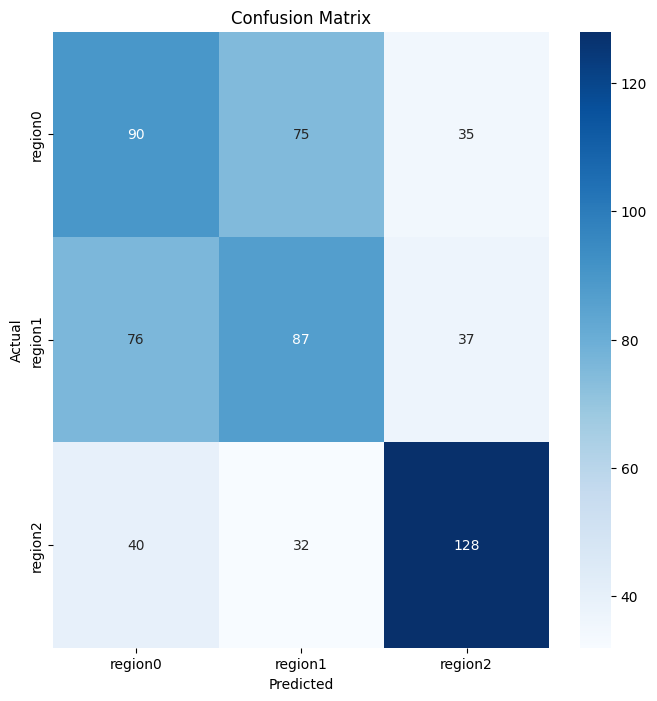

f1_score of class 0 : 0.44
recall_score of class 0 : 0.45
precision_score of class 0 : 0.44

f1_score of class 1 : 0.44
recall_score of class 1 : 0.43
precision_score of class 1 : 0.45

f1_score of class 2 : 0.64
recall_score of class 2 : 0.64
precision_score of class 2 : 0.64

accuracy: 0.5083
f1-score (macro) : 0.5083


In [401]:
cm = confusion_matrix(y_test, y_pred)

target_classes = ['region0', 'region1', 'region2']

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=target_classes, 
            yticklabels=target_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

f1_scores = f1_score(y_true=y_test, y_pred=y_pred, average=None)
recalls = recall_score(y_true=y_test, y_pred=y_pred, average=None)
precisions = precision_score(y_true=y_test, y_pred=y_pred, average=None)

for i in range(len(f1_scores)):
    print(f"f1_score of class {i} : {f1_scores[i]:.2f}")
    print(f"recall_score of class {i} : {recalls[i]:.2f}")
    print(f"precision_score of class {i} : {precisions[i]:.2f}")
    print()

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"f1-score (macro) : {f1_score(y_test, y_pred, average='macro'):.4f}")

In [402]:
from xgboost import plot_tree

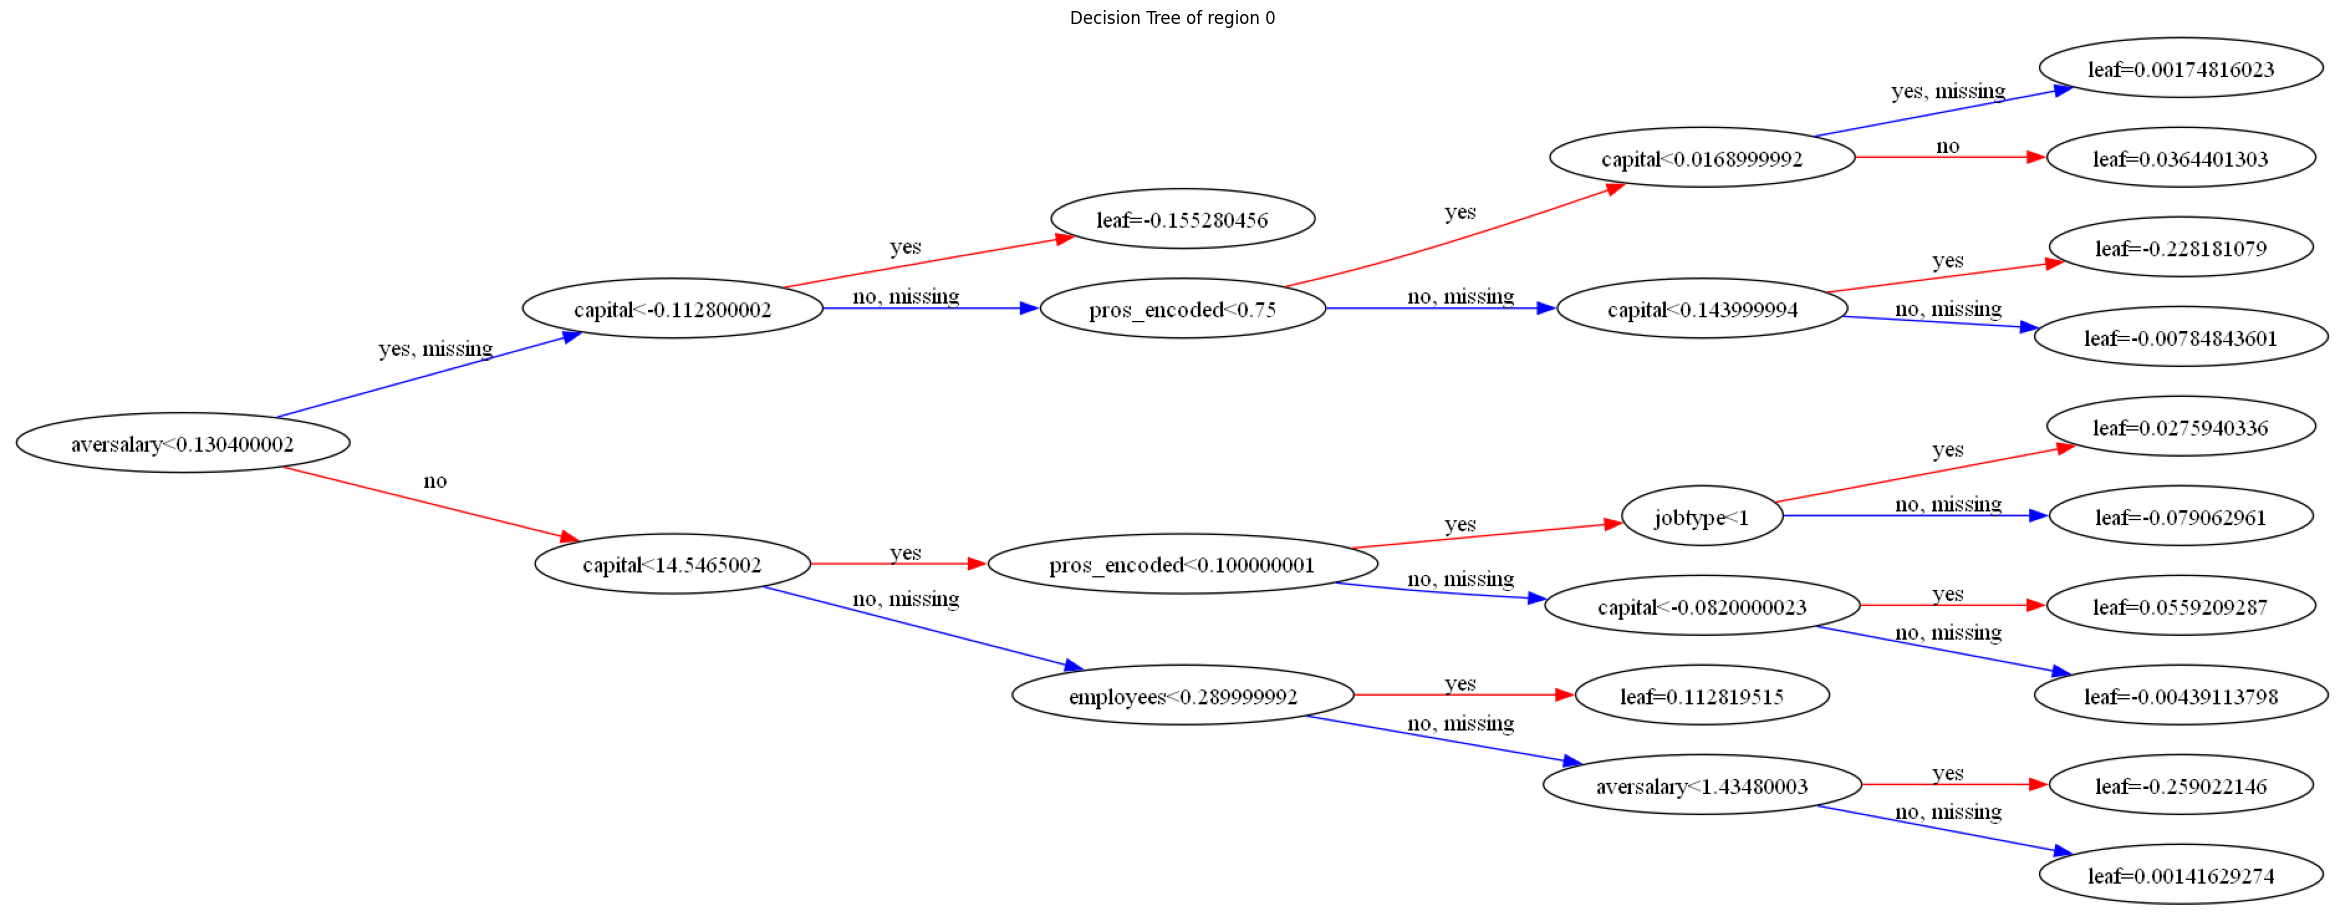

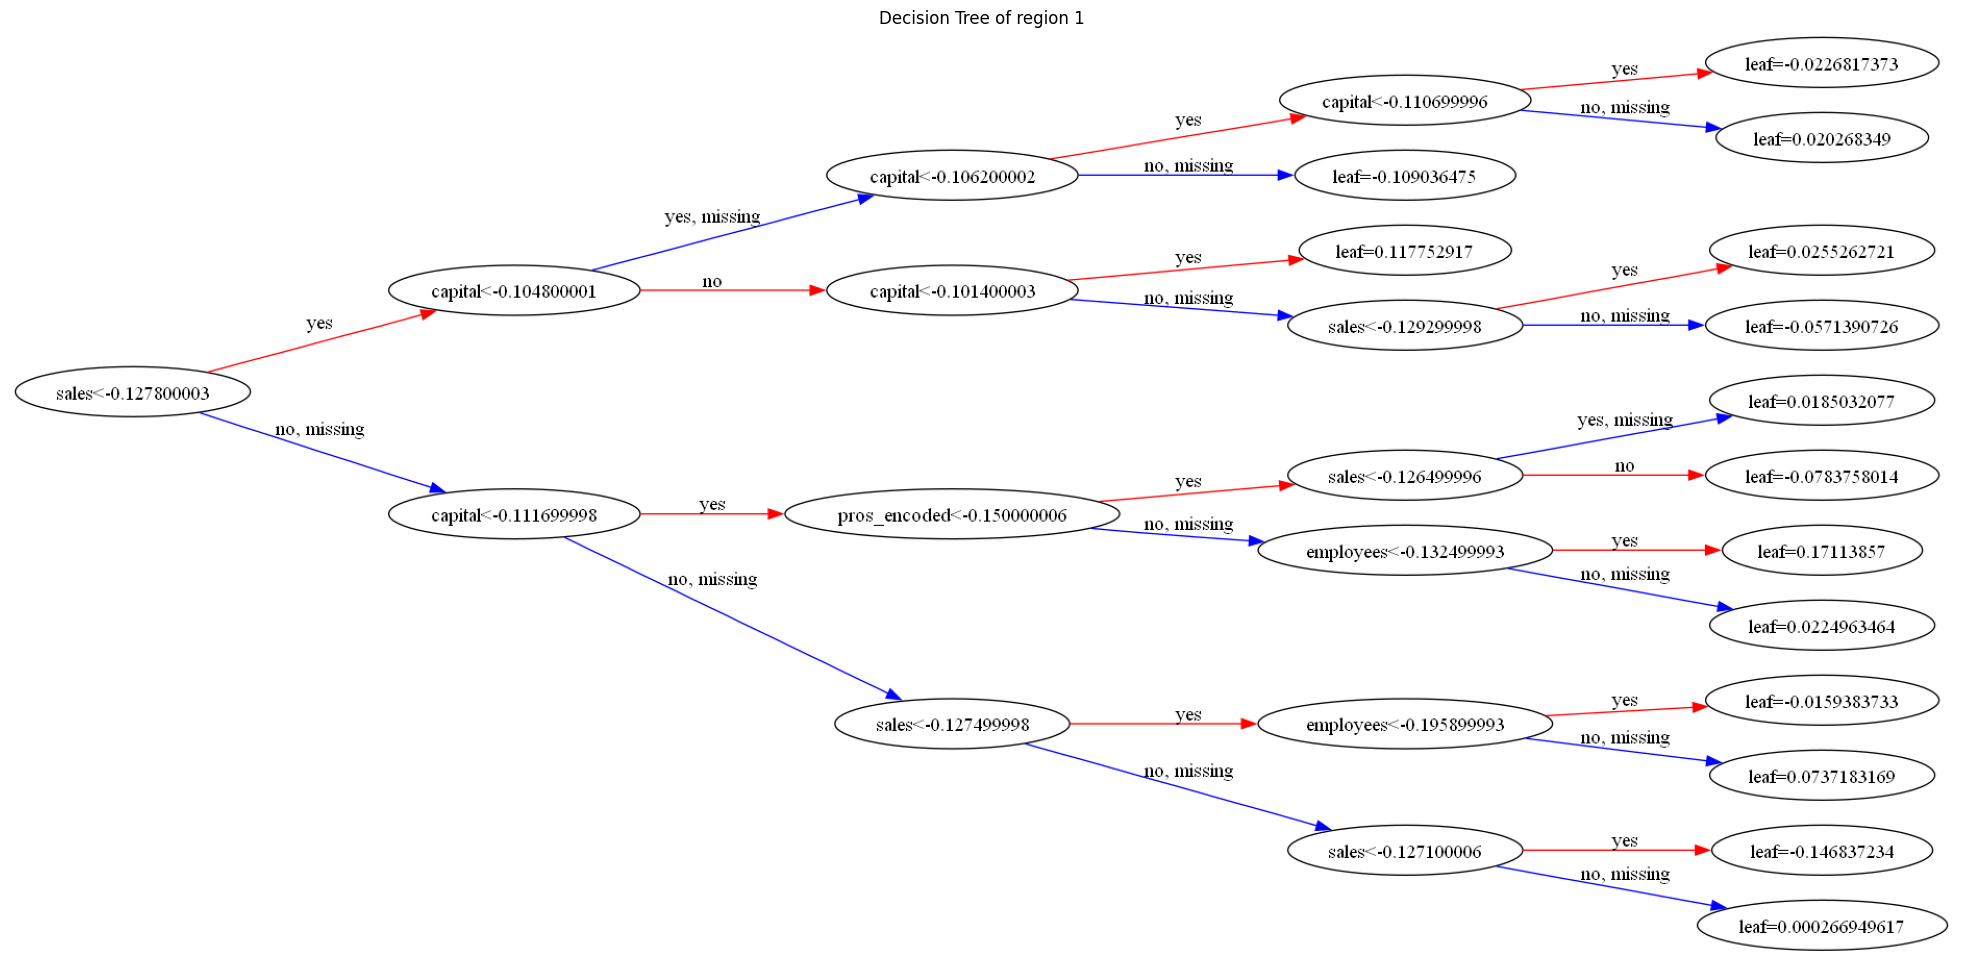

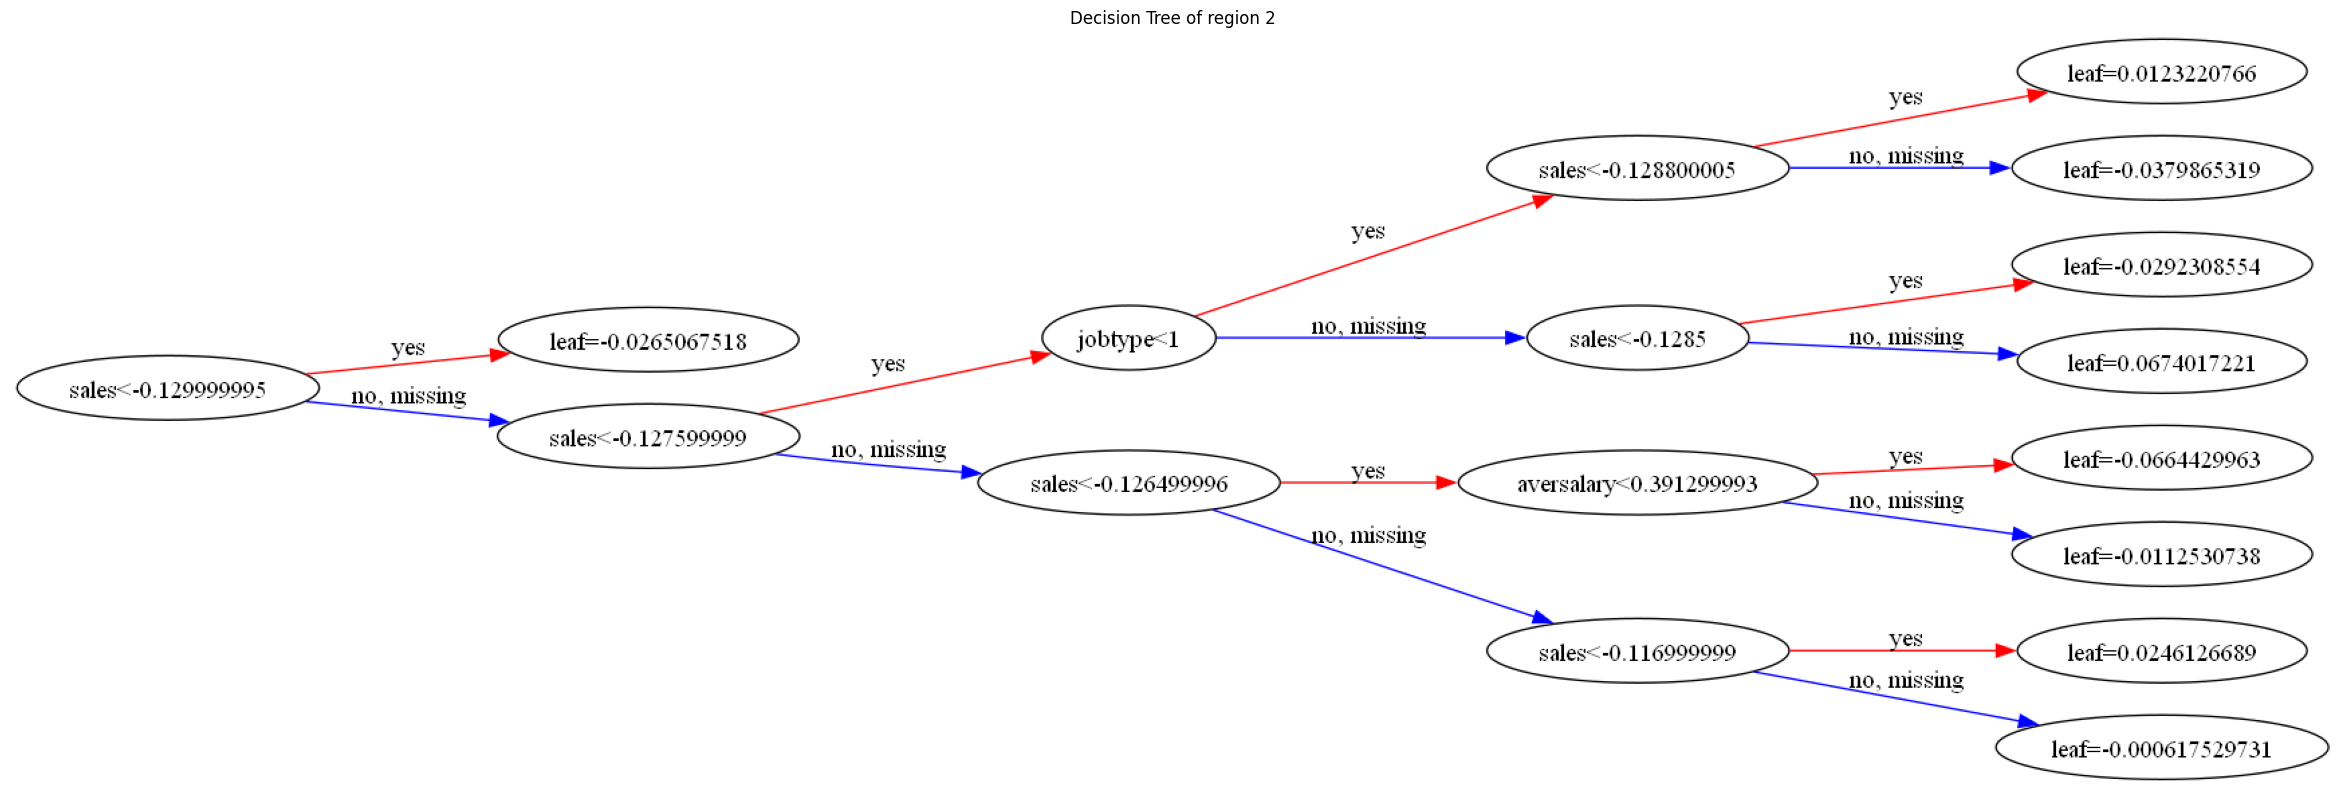

In [403]:
# best_params
# {'n_estimators': 190, 'max_depth': 4, 'learning_rate': 0.62}

for class_region in [0, 1, 2]:
    # num_tree 는 best_params 에 맞춰 하드 코딩된 값
    num_tree = (class_region * 190) + 189

    # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
    plot_tree(xgb_clf_tuned, num_trees=num_tree, rankdir='LR')
    fig = plt.gcf()
    fig.set_size_inches(30, 12)

    # 이미지 저장
    fig.savefig(f'tree_class{class_region}.png')

    plt.title(f'Decision Tree of region {class_region}')
    plt.show()

### 최종 분류 모델의 Feature importance

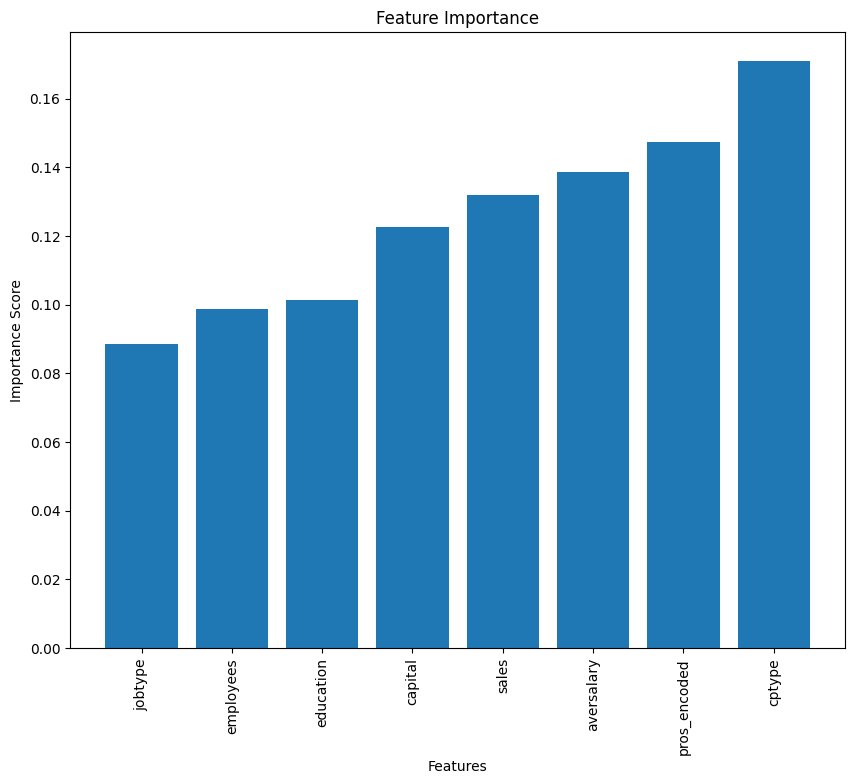

In [404]:
feature_importance = xgb_clf_tuned.feature_importances_
# 오름차순 정렬 시 인덱스
sorted_idx = np.argsort(feature_importance)

X = df.iloc[:, 1:]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

결측값이 존재하는 상태 (종속변수에는 결측값이 존재하지 않는다.) 에서 언더샘플링 한 데이터를 모델학습에 사용하였다.  
또한, 결측값을 포함해 학습하기 위해 xgboost 사용하였다.  

해당 모델을 사용하여 '구인 공고에 등록된 정보' 를 가지고 '구인 공고가 올라온 지역' 을 예측한 결과,  
테스트 정확도 약 0.5083 , f1-score 는 약 0.5083 이었다.  
무작위 예측 시 정확도는 약 0.3637 이고, 무조건 '지방 지역' 으로 예측하는 모델 정확도 0.4725 임을 감안하더라도  
만족할 만큼 높은 수치는 아니다.  

#### 따라서 < 1. 구인 공고 데이터로 지역 예측이 가능할 것이다 (지도학습). > 는 틀렸다고 판단된다.  

## 가설 검정  
검정 과정 이전에 결측값 처리가 필요하므로, 모델학습에 사용한 것과 달리 결측값은 모두 drop 처리하였다.

['region' 'education' 'jobtype' 'cptype' 'sales' 'employees' 'aversalary'
 'capital' 'pros_encoded']
region
0    1424
1     876
2     715
Name: count, dtype: int64
num_region0 (dropna) :  780
num_region1 (dropna) :  440
num_region2 (dropna) :  432


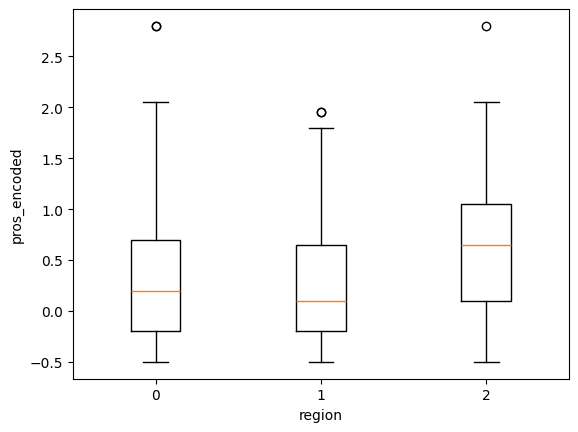

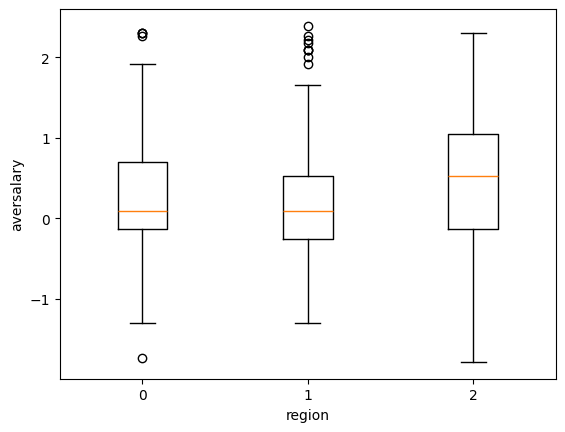

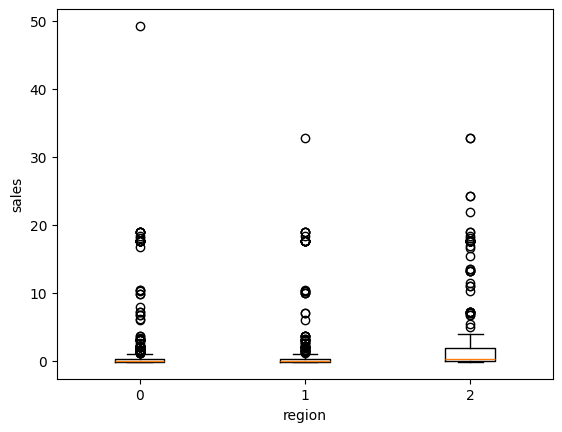

In [405]:
df = pd.read_csv('data_beforeScaling.csv', encoding='utf-8-sig', index_col=0)

print(df.columns.values)
print(df['region'].value_counts())

region_0 = df_dropna[df_dropna['region'] == 0]
region_1 = df_dropna[df_dropna['region'] == 1]
region_2 = df_dropna[df_dropna['region'] == 2]

print("num_region0 (dropna) : ", len(region_0))
print("num_region1 (dropna) : ", len(region_1))
print("num_region2 (dropna) : ", len(region_2))

# 튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric type 항목
features = ['pros_encoded', 'aversalary', 'sales']

for feature in features:
    plot_data = [region_0[feature], region_1[feature], region_2[feature]]
    ax = plt.boxplot(plot_data, labels=[0, 1, 2])
    plt.xlabel("region")
    plt.ylabel(feature)
    plt.show()

### ONE-WAY ANOVA TEST

튜닝된 XgboostClassifier 에서 feature importance 상위 3개 Numeric 피쳐  
['pros_encoded', 'aversalary', 'sales'] 에 대해 One-way ANOVA 검정 수행  

표본평균이 통계적으로 유의미한 수준으로 차이남을 확인  

정규성은 만족하지 않으나, bartlett's test 를 통해 등분산성 확인.  
ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett

정규성은 만족하지 않으나, 비모수 검정보다 모수 검정이 더 유효하다고 판단  
중심 극한 정리에 의해 정규성을 따르지 않더라도 모수적 검정이 가능하다는 글을 참고하였다.  
ref 1. https://blog.minitab.com/ko/adventures-in-statistics-2/choosing-between-a-nonparametric-test-and-a-parametric-test  
ref 2. https://statisticsbyjim.com/hypothesis-testing/nonparametric-parametric-tests/

In [406]:
from scipy import stats

In [412]:
features = ['pros_encoded', 'aversalary', 'sales']

print("정규성 만족 확인")
# pvalue > 0.05 이상이면 정규성 만족
for feature in features:
    print(feature)
    print(f"{stats.shapiro(region_0[feature]).pvalue:.8f}")
    print(f"{stats.shapiro(region_1[feature]).pvalue:.8f}")
    print(f"{stats.shapiro(region_2[feature]).pvalue:.8f}")

# 등분산성 확인
print("\n등분산성 확인 (bartlett's test)")
for feature in features:
    print(feature)
    # 통상적인 유의수준 0.05 (5%) 보다 낮으므로 각 집단 분산이 다르다.
    # The very small p-value suggests that the populations do not have equal variances.
    # ref. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett
    
    print(f"{stats.bartlett(region_0[feature], region_1[feature], region_2[feature]).pvalue:.8f}")

print("\none-way ANOVA")
for feature in features:
    print(feature)
    print(stats.f_oneway(region_0[feature], region_1[feature], region_2[feature]))

정규성 만족 확인
pros_encoded
0.00000000
0.00000000
0.00000408
aversalary
0.00000000
0.00000070
0.00000000
sales
0.00000000
0.00000000
0.00000000

등분산성 확인 (bartlett's test)
pros_encoded
0.02996645
aversalary
0.00000000
sales
0.00000000

one-way ANOVA
pros_encoded
F_onewayResult(statistic=54.41740370023298, pvalue=1.3002302415233098e-23)
aversalary
F_onewayResult(statistic=5.923864490850419, pvalue=0.002732099281766318)
sales
F_onewayResult(statistic=26.510482132875524, pvalue=4.654428013528492e-12)


### ANOVA test 후 사후 검정

지역마다 아래 3개 피쳐의 표본평균값에대해 유의미한 차이가 존재하는지 분석해보았다.  
아래 3개 피쳐는 수치형 데이터 타입 피쳐 중에서 최종 모델의 피쳐 중요도 상위 3 개 피쳐로 선정하였다.

<검정 결과>  
[pros_encoded]  

지역마다 통계적으로 유의미한 수준으로 차이난다.

[aversalary]  

(지방 - 비수도권 광역시), (지방 - 수도권) 의 차이는 무의미하다. 비수도권 광역시-수도권 의 차이는 유의미하다.  

[sales]  

(지방 - 비수도권 광역시) 사이는 무의미, (지방 - 수도권) 과 (비수도권 - 수도권) 사이는 유의미한 차이 존재.

In [408]:
import scikit_posthocs as sp

print("### scheffe's test ###")

features = ['pros_encoded', 'aversalary', 'sales']

for feature in features:
    x = pd.DataFrame({'0':region_0[feature].reset_index(drop=True), 
                      '1':region_1[feature].reset_index(drop=True), 
                      '2':region_2[feature].reset_index(drop=True)})

    x = x.melt(var_name='region', value_name=feature)

    x = x.dropna() # 지역마다 표본 수 동일

    # scheffe's test
    print("\n",feature)
    print(sp.posthoc_scheffe(x, val_col=feature, group_col='region'))

### scheffe's test ###

 pros_encoded
              0             1             2
0  1.000000e+00  1.517594e-02  1.938339e-15
1  1.517594e-02  1.000000e+00  1.842321e-21
2  1.938339e-15  1.842321e-21  1.000000e+00

 aversalary
          0         1         2
0  1.000000  0.197021  0.112832
1  0.197021  1.000000  0.002767
2  0.112832  0.002767  1.000000

 sales
              0             1             2
0  1.000000e+00  7.289679e-01  2.459122e-11
1  7.289679e-01  1.000000e+00  2.556473e-07
2  2.459122e-11  2.556473e-07  1.000000e+00


In [413]:
print(f"{region_0['pros_encoded'].mean():.6f}")
print(f"{region_1['pros_encoded'].mean():.6f}")
print(f"{region_2['pros_encoded'].mean():.6f}")
print()

print(f"{region_0['aversalary'].mean():.6f}")
print(f"{region_1['aversalary'].mean():.6f}")
print(f"{region_2['aversalary'].mean():.6f}")
print()

print(f"{region_0['sales'].mean():.6f}")
print(f"{region_1['sales'].mean():.6f}")
print(f"{region_2['sales'].mean():.6f}")
print()

0.309167
0.210227
0.594792

0.251618
0.170652
0.346022

0.962876
1.172077
2.826346

